In [ ]:
# ===== 0) SETUP =====
!pip -q install pandas numpy matplotlib seaborn scikit-learn statsmodels openpyxl

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

USE_GOOGLE_DRIVE = True   # set False if you'll upload files into /content

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/airbnb_seattle"   # <-- adjust if needed
    LISTINGS_F = os.path.join(BASE_DIR, "listings.csv")
    REVIEWS_F  = os.path.join(BASE_DIR, "reviews.csv")
    NEIGH_F    = os.path.join(BASE_DIR, "neighbourhoods.xlsx")  # <-- UPDATED
else:
    LISTINGS_F = "/content/listings.csv"
    REVIEWS_F  = "/content/reviews.csv"
    NEIGH_F    = "/content/neighbourhoods.xlsx"                  # <-- UPDATED

for pth in [LISTINGS_F, REVIEWS_F, NEIGH_F]:
    assert os.path.exists(pth), f"Missing file: {pth}"
print("✅ Paths OK")


Mounted at /content/drive
✅ Paths OK


In [ ]:
# ===== 1) LOAD =====
low_mem = False
listings = pd.read_csv(LISTINGS_F, low_memory=low_mem)
reviews  = pd.read_csv(REVIEWS_F,  low_memory=low_mem)

# neighbourhoods.xlsx -> read first sheet (change sheet_name if yours differs)
neigh = pd.read_excel(NEIGH_F, sheet_name=0)

print("Listings:", listings.shape, " Reviews:", reviews.shape, " Neigh:", neigh.shape)
display(neigh.head())


Listings: (6862, 79)  Reviews: (541092, 6)  Neigh: (90, 2)


,neighbourhood_group,neighbourhood
0,Ballard,Adams
1,Ballard,Loyal Heights
2,Ballard,Sunset Hill
3,Ballard,West Woodland
4,Ballard,Whittier Heights


In [ ]:
# ===== 1b) LOAD CALENDAR (parsed from filenames) =====
# Expected columns: listing_id, date, available, price, adjusted_price, minimum_nights, maximum_nights
# (price columns may be empty for your set — that's OK)

CAL_F_CSV  = os.path.join(BASE_DIR, "calendar_from_filenames.csv")
CAL_F_XLSX = os.path.join(BASE_DIR, "calendar_from_filenames.xlsx")

calendar = None
if os.path.exists(CAL_F_CSV):
    calendar = pd.read_csv(CAL_F_CSV, parse_dates=["date"], dtype={"listing_id": "Int64"})
elif os.path.exists(CAL_F_XLSX):
    calendar = pd.read_excel(CAL_F_XLSX, parse_dates=["date"], dtype={"listing_id": "Int64"})
else:
    calendar = pd.DataFrame(columns=["listing_id","date","available","price","adjusted_price",
                                     "minimum_nights","maximum_nights"])

# Normalize dtypes
if "available" in calendar.columns:
    # your IDLE script used {"t": True, "f": False}; ensure boolean dtype here
    calendar["available"] = calendar["available"].astype("boolean")

for col in ["minimum_nights","maximum_nights","price","adjusted_price"]:
    if col in calendar.columns:
        calendar[col] = pd.to_numeric(calendar[col], errors="coerce")

print("Calendar shape:", calendar.shape)
calendar.head(3)


Calendar shape: (28410, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1000759703389256195,2025-06-30,False,NaN,NaN,30,1125
1,1000759703389256195,2025-07-01,False,NaN,NaN,30,1125
2,1000759703389256195,2025-07-02,False,NaN,NaN,30,1125


In [ ]:
# ===== 2) HELPERS =====
def parse_money(series):
    # handles $, commas, blanks
    s = pd.Series(series, dtype="string")
    return pd.to_numeric(s.str.replace(r"[\$,]", "", regex=True), errors="coerce")

def bathrooms_to_num(df):
    if "bathrooms_num" in df.columns and pd.api.types.is_numeric_dtype(df["bathrooms_num"]):
        return df["bathrooms_num"].astype(float)
    src = "bathrooms_text" if "bathrooms_text" in df.columns else ("bathrooms" if "bathrooms" in df.columns else None)
    if src is None:
        return pd.Series(np.nan, index=df.index)
    return (
        df[src].astype(str)
              .str.extract(r"([0-9]*\.?[0-9]+)", expand=False)
              .astype(float)
    )


In [ ]:
# ===== 3) CLEAN + FEATURE ENGINEERING =====

df = listings.copy()

# Money fields
for col in ["price","security_deposit","cleaning_fee","extra_people"]:
    if col in df.columns:
        df[col] = parse_money(df[col])

# Bathrooms numeric
df["bathrooms_num"] = bathrooms_to_num(df)

# Robust price and log target
p = df["price"].astype(float)
lo, hi = np.nanpercentile(p, [1, 99])
df["price_clipped"] = p.clip(lo, hi)
df["log_price"] = np.log1p(df["price_clipped"])

# Amenities processing
df["amenities"] = df["amenities"].astype(str).str.lower()
df["amenity_count"] = df["amenities"].str.count(",") + 1

# Pick a practical set you can justify in the paper
top_amenities = [
    "air conditioning","hot tub","pool","bbq grill","waterfront",
    "mountain view","crib","workspace","fire pit","gym"
]
for a in top_amenities:
    df[a.replace(" ", "_")] = df["amenities"].str.contains(a, regex=False).astype(int)

# Simple capacity proxy (note: we'll drop if multicollinear in modeling)
for c in ["accommodates","bedrooms","bathrooms_num"]:
    if c not in df.columns: df[c] = np.nan
df["size_index"] = (
    df["accommodates"].fillna(0)*1.0 +
    df["bedrooms"].fillna(0)*1.5 +
    df["bathrooms_num"].fillna(0)*1.5
)

# Review recency features
if not reviews.empty:
    r = reviews.copy()
    r["date"] = pd.to_datetime(r["date"], errors="coerce")
    rmax = r["date"].max()
    r["is_90d"] = r["date"] >= (rmax - pd.Timedelta(days=90))
    r_agg = (r.groupby("listing_id")
               .agg(review_count=("id","size"),
                    reviews_90d=("is_90d","sum"),
                    last_review=("date","max"))
               .reset_index()
               .rename(columns={"listing_id":"id"}))
    df = df.merge(r_agg, on="id", how="left")
    df[["review_count","reviews_90d"]] = df[["review_count","reviews_90d"]].fillna(0)
else:
    df["review_count"] = 0
    df["reviews_90d"] = 0
    df["last_review"] = pd.NaT

# Neighborhood tiers by median price (High/Mid/Low)
if "neighbourhood_cleansed" in df.columns:
    neigh_meds = (df.groupby("neighbourhood_cleansed")["price"]
                    .median().dropna().sort_values(ascending=False))
    hi_q = neigh_meds.quantile(0.80)
    lo_q = neigh_meds.quantile(0.20)
    def tier(v):
        if v >= hi_q: return "High"
        if v <= lo_q: return "Low"
        return "Mid"
    tiers = neigh_meds.apply(tier).to_dict()
    df["neigh_tier"] = df["neighbourhood_cleansed"].map(tiers)
else:
    df["neigh_tier"] = np.nan

# Multi-listing host
if "host_id" in df.columns:
    host_counts = df["host_id"].value_counts()
    multi_hosts = host_counts[host_counts > 1].index
    df["multi_listing_host"] = df["host_id"].isin(multi_hosts).astype(int)
else:
    df["multi_listing_host"] = np.nan

# KEEP: your engineered table for later steps
df_fe = df.copy()   # <-- so downstream cells find it without errors
print("✅ Feature engineering complete. df_fe shape:", df_fe.shape)


✅ Feature engineering complete. df_fe shape: (6862, 99)


In [ ]:
# ===== 3b) CALENDAR FEATURE ENGINEERING & MERGE =====
import numpy as np

def build_calendar_features(cal_df, windows=(30, 90, 180)):
    """Create availability/booking-rule features per listing_id."""
    if cal_df.empty:
        return pd.DataFrame(columns=["listing_id"])

    c = cal_df.copy()
    c = c.dropna(subset=["listing_id","date"]).sort_values(["listing_id","date"])
    c["listing_id"] = c["listing_id"].astype("int64")

    # Base aggregates over full span
    base = (c.groupby("listing_id")
              .agg(
                  cal_days=("date","count"),
                  avail_rate_full=("available","mean"),
                  min_nights_median=("minimum_nights","median"),
                  max_nights_median=("maximum_nights","median"),
                  min_nights_mean=("minimum_nights","mean"),
                  price_volatility=("price","std"),           # may be NaN if prices are empty
                  adjusted_price_volatility=("adjusted_price","std")
              )
              .reset_index())

    # Weekend availability ratio (Fri/Sat)
    c["weekday"] = c["date"].dt.weekday  # Mon=0, Sun=6; weekend = 4,5 for Fri/Sat or 5,6 (pick your def)
    weekend_mask = c["weekday"].isin([4,5])  # Fri, Sat
    wknd = (c[weekend_mask]
            .groupby("listing_id")["available"]
            .mean()
            .rename("avail_rate_weekend")
            .reset_index())
    base = base.merge(wknd, on="listing_id", how="left")

    # Rolling windows relative to latest date in calendar
    max_date = c["date"].max()
    for d in windows:
        cut = max_date - pd.Timedelta(days=d)
        sub = c[c["date"] >= cut]
        feat = (sub.groupby("listing_id")
                  .agg(**{
                      f"avail_rate_{d}d": ("available","mean"),
                      f"open_days_{d}d": ("available", "sum"),       # True counts as 1
                      f"calendar_rows_{d}d": ("date","count")
                  })
                  .reset_index())
        base = base.merge(feat, on="listing_id", how="left")

    # Booking horizon (how far into the future we have rows)
    horizon = (c.groupby("listing_id")
                 .agg(first_date=("date","min"), last_date=("date","max"))
                 .reset_index())
    horizon["calendar_span_days"] = (horizon["last_date"] - horizon["first_date"]).dt.days
    base = base.merge(horizon[["listing_id","calendar_span_days"]], on="listing_id", how="left")

    return base

cal_feats = build_calendar_features(calendar, windows=(30,90,180))
print("Calendar features shape:", cal_feats.shape)

# Merge into df_fe (listings table)
if not cal_feats.empty:
    df_fe = df_fe.merge(cal_feats, left_on="id", right_on="listing_id", how="left")
    print("After merge, df_fe:", df_fe.shape)
else:
    print("No calendar features to merge (calendar empty).")


Calendar features shape: (79, 19)
After merge, df_fe: (6862, 118)



Basic Summary (key cols)
             price  price_clipped    log_price  accommodates     bedrooms  \
count       6227.0    6227.000000  6227.000000   6862.000000  6747.000000   
mean    473.938494     225.232761     5.210133      4.077237     1.670668   
std    3290.410859     181.580817     0.623902      2.660859     1.214488   
min           10.0      44.000000     3.806662      1.000000     0.000000   
25%          119.0     119.000000     4.787492      2.000000     1.000000   
50%          177.0     177.000000     5.181784      4.000000     1.000000   
75%          269.0     269.000000     5.598422      6.000000     2.000000   
max        50034.0    1289.800000     7.163017     16.000000    17.000000   

       bathrooms_num  amenity_count  review_count  reviews_90d  \
count    6849.000000    6862.000000   6862.000000  6862.000000   
mean        1.453205      44.077820     78.853396     3.935004   
std         0.803009      15.497166    122.728138     5.277726   
min         0.00

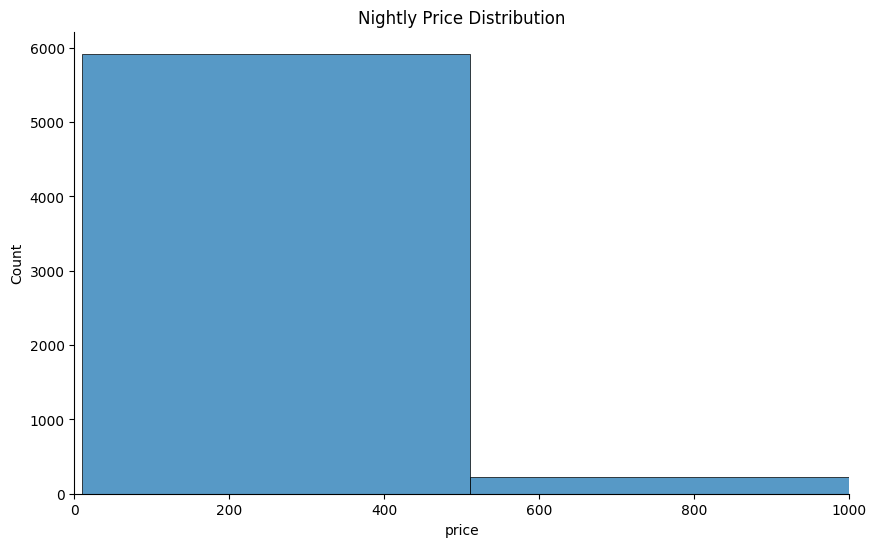

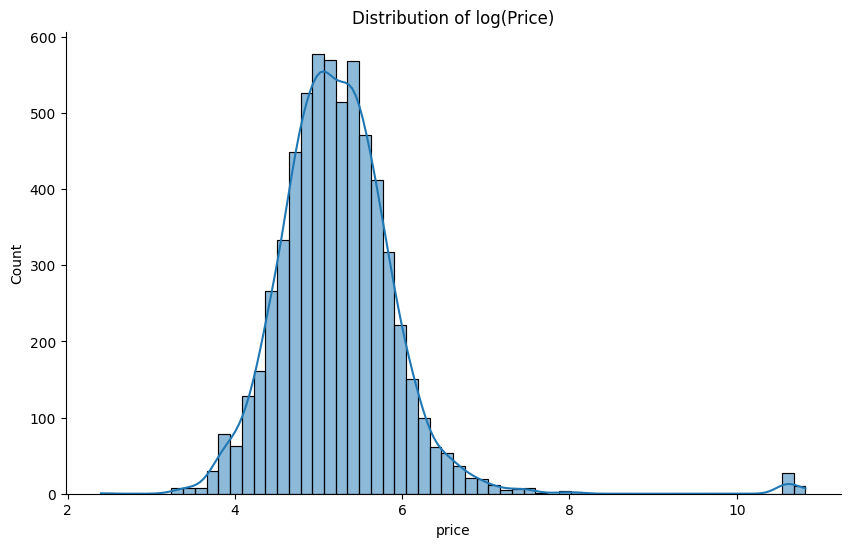

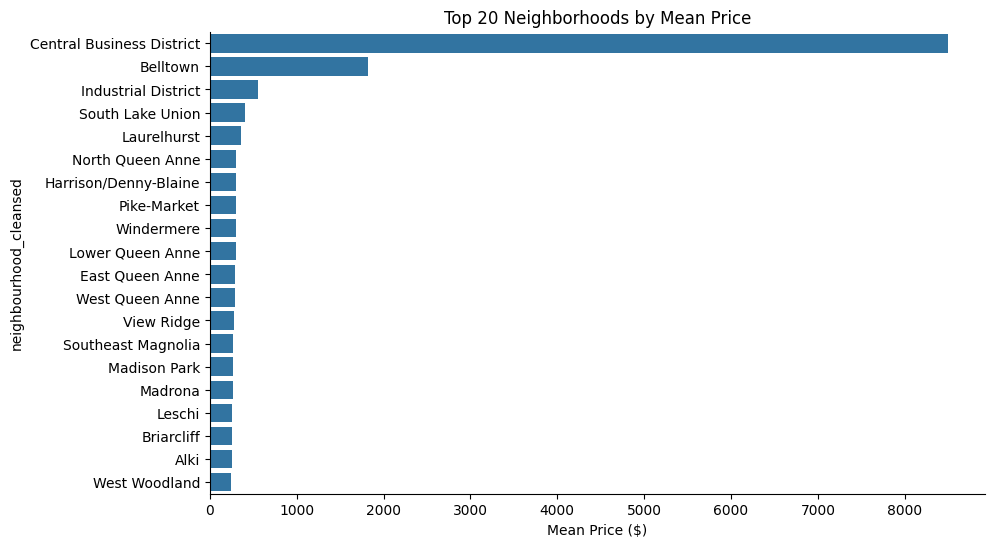

,mean,median,count
neighbourhood_cleansed,,,
Central Business District,8496.133858,309.0,127
Belltown,1825.394813,225.0,347
Industrial District,553.0,553.0,1
South Lake Union,408.267857,329.5,112
Laurelhurst,353.833333,208.0,24
North Queen Anne,305.72973,210.0,111
Harrison/Denny-Blaine,298.6,221.0,25
Pike-Market,298.349398,287.0,83
Windermere,297.357143,168.5,14


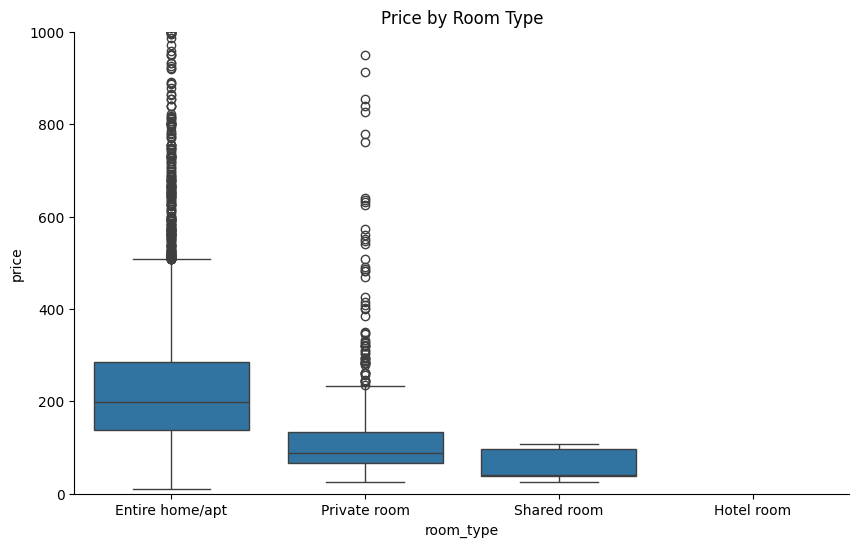

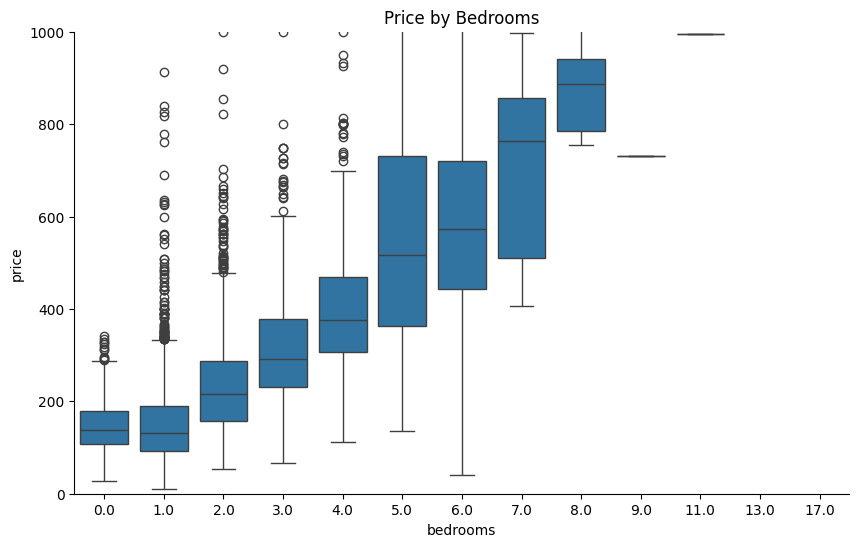

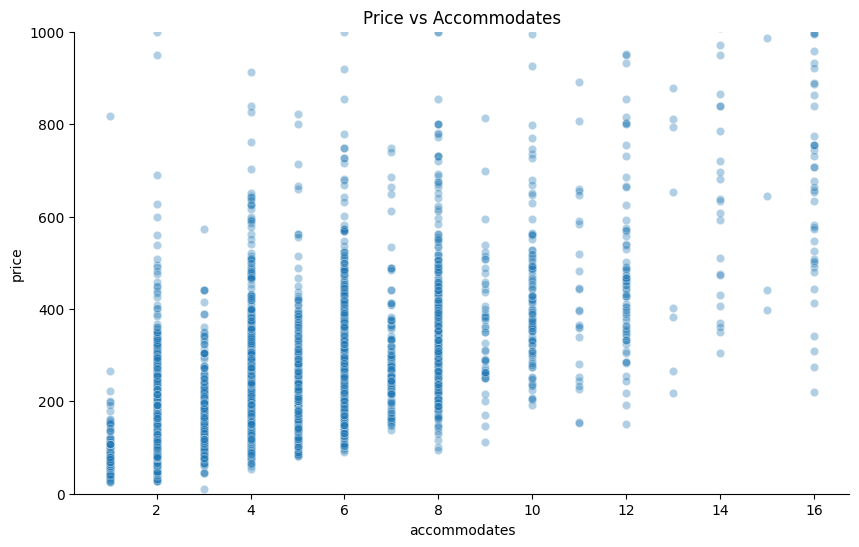

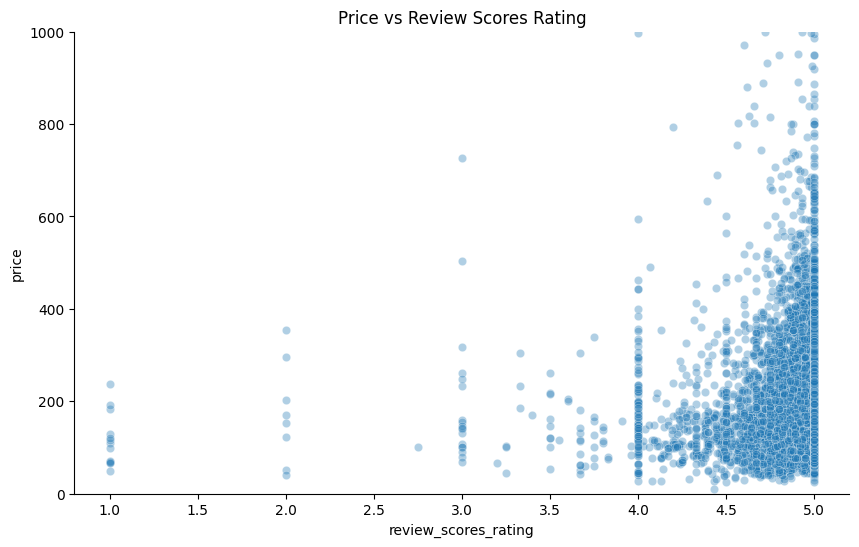

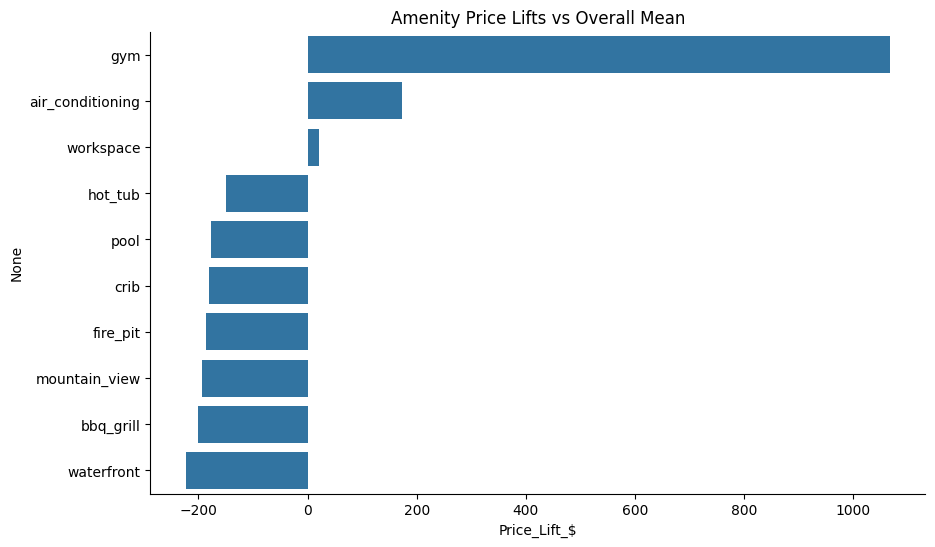

,Price_Lift_$
gym,1067.018852
air_conditioning,173.806048
workspace,20.510536
hot_tub,-148.489379
pool,-175.952848
crib,-179.666046
fire_pit,-185.964618
mountain_view,-193.380725
bbq_grill,-200.937403
waterfront,-223.484471


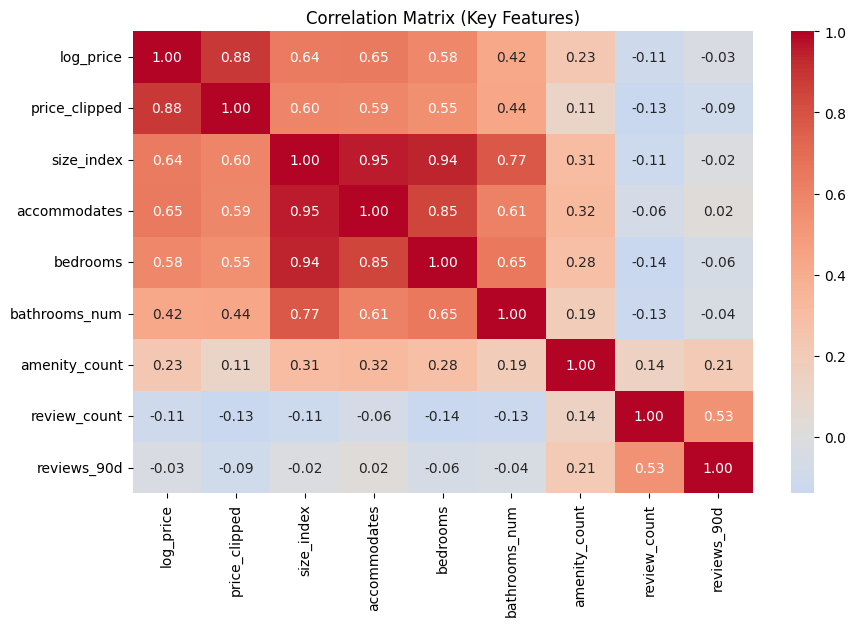

In [ ]:
# ===== 4) EDA =====

def nice_print(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# Summary
nice_print("Basic Summary (key cols)")
print(df_fe[["price","price_clipped","log_price","accommodates","bedrooms","bathrooms_num",
             "amenity_count","review_count","reviews_90d","number_of_reviews"]]
      .describe(include="all"))

# Distributions
sns.histplot(df_fe["price"].dropna(), bins=100)
plt.xlim(0, 1000); plt.title("Nightly Price Distribution"); plt.show()

sns.histplot(np.log1p(df_fe["price"].dropna()), bins=60, kde=True)
plt.title("Distribution of log(Price)"); plt.show()

# Neighborhood prices
if "neighbourhood_cleansed" in df_fe.columns:
    neigh_summary = (df_fe.groupby("neighbourhood_cleansed")["price"]
                       .agg(["mean","median","count"])
                       .sort_values("mean", ascending=False).head(20))
    sns.barplot(x=neigh_summary["mean"], y=neigh_summary.index, orient="h")
    plt.title("Top 20 Neighborhoods by Mean Price"); plt.xlabel("Mean Price ($)"); plt.show()
    display(neigh_summary)

# Room type vs price
if "room_type" in df_fe.columns:
    sns.boxplot(x="room_type", y="price", data=df_fe)
    plt.ylim(0,1000); plt.title("Price by Room Type"); plt.show()

# Bedrooms vs price
sns.boxplot(x="bedrooms", y="price", data=df_fe)
plt.ylim(0,1000); plt.title("Price by Bedrooms"); plt.show()

# Price vs accommodates
sns.scatterplot(x="accommodates", y="price", data=df_fe, alpha=0.35)
plt.ylim(0,1000); plt.title("Price vs Accommodates"); plt.show()

# Review scores vs price (if present)
if "review_scores_rating" in df_fe.columns:
    sns.scatterplot(x="review_scores_rating", y="price", data=df_fe, alpha=0.35)
    plt.ylim(0,1000); plt.title("Price vs Review Scores Rating"); plt.show()

# Amenity lifts (how much above overall mean)
amen_cols = [c for c in df_fe.columns if c in [a.replace(" ","_") for a in [
    "air conditioning","hot tub","pool","bbq grill","waterfront",
    "mountain view","crib","workspace","fire pit","gym"
]]]
lifts = {}
overall = df_fe["price"].mean()
for a in amen_cols:
    lifts[a] = df_fe.loc[df_fe[a]==1, "price"].mean() - overall
amen_df = pd.DataFrame.from_dict(lifts, orient="index", columns=["Price_Lift_$"]).sort_values("Price_Lift_$", ascending=False)
sns.barplot(x="Price_Lift_$", y=amen_df.index, data=amen_df, orient="h")
plt.title("Amenity Price Lifts vs Overall Mean"); plt.show()
display(amen_df)

# Correlations (engineered features)
corr_cols = [
    "log_price","price_clipped","size_index","accommodates","bedrooms",
    "bathrooms_num","amenity_count","review_count","reviews_90d"
]
corr_cols = [c for c in corr_cols if c in df_fe.columns]
corr = df_fe[corr_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Key Features)"); plt.show()


In [ ]:
# ===== 5) MODELING TABLE (now with calendar features) =====

# Drop 'size_index' to avoid linear dependency with beds/baths/accommodates later
drop_cols = [c for c in ["size_index"] if c in df_fe.columns]
dfm = df_fe.drop(columns=drop_cols).copy()

target = "log_price"
assert target in dfm.columns, "log_price missing."

# Original numeric features
num_features = [c for c in [
    "accommodates","bedrooms","bathrooms_num","amenity_count",
    "review_count","reviews_90d","minimum_nights","maximum_nights",
    "cleaning_fee","security_deposit","extra_people"
] if c in dfm.columns]

# >>> New calendar numeric features (only added if present) <<<
cal_num = [c for c in [
    "cal_days","avail_rate_full","avail_rate_weekend",
    "avail_rate_30d","avail_rate_90d","avail_rate_180d",
    "open_days_30d","open_days_90d","open_days_180d",
    "calendar_rows_30d","calendar_rows_90d","calendar_rows_180d",
    "min_nights_median","max_nights_median","min_nights_mean",
    "calendar_span_days","price_volatility","adjusted_price_volatility"
] if c in dfm.columns]

num_features = num_features + cal_num

cat_features = [c for c in ["room_type","neigh_tier"] if c in dfm.columns]

# Amenity binaries (unchanged)
amen_cols = [c for c in [a.replace(" ","_") for a in [
    "air conditioning","hot tub","pool","bbq grill","waterfront",
    "mountain view","crib","workspace","fire pit","gym"
]] if c in dfm.columns]

use_cols = ["id", target] + num_features + cat_features + amen_cols

model_df = dfm[use_cols].dropna(subset=[target]).copy()

# One-hot encode categoricals
df_flat = pd.get_dummies(model_df, columns=cat_features, drop_first=True, dtype=np.int8)
df_flat = df_flat.replace([np.inf, -np.inf], np.nan).dropna(subset=[target])

print("Modeling table:", df_flat.shape)
df_flat.head(3)


Modeling table: (6227, 43)


,id,log_price,accommodates,bedrooms,bathrooms_num,amenity_count,review_count,reviews_90d,minimum_nights,maximum_nights,...,mountain_view,crib,workspace,fire_pit,gym,room_type_Hotel room,room_type_Private room,room_type_Shared room,neigh_tier_Low,neigh_tier_Mid
0,6606,4.820282,1,1.0,1.0,29,161.0,0.0,30,1125,...,0,0,1,0,0,0,0,0,0,1
1,9419,4.488636,2,1.0,3.0,54,212.0,2.0,2,90,...,0,0,1,0,0,0,1,0,1,0
3,11012,5.739793,8,3.0,2.0,41,98.0,0.0,30,120,...,0,1,1,0,0,0,0,0,0,1


In [ ]:
# --- Smart-ish imputation before modeling ---
# --- Smart, safe imputation before modeling (no KeyErrors) ---

def impute_by_group(df, target_col, group_cols=None, fallback="median"):
    """
    Fills NaNs in target_col.
    If group_cols is empty or none exist in df, falls back to global fill (median or 0).
    """
    df = df.copy()
    # keep only groupers that actually exist
    if group_cols is None:
        group_cols = []
    group_cols = [c for c in group_cols if c in df.columns]

    # choose global fallback
    global_fill = df[target_col].median() if fallback == "median" else 0

    # if no valid groupers, just global fill
    if len(group_cols) == 0:
        df[target_col] = df[target_col].fillna(global_fill)
        return df

    # otherwise groupwise median, then global fallback
    med = (
        df.groupby(group_cols, dropna=False)[target_col]
          .median()
          .rename("grp_med")
          .reset_index()
    )
    tmp = df[group_cols + [target_col]].merge(med, on=group_cols, how="left")
    df[target_col] = df[target_col].fillna(tmp["grp_med"]).fillna(global_fill)
    return df

# ---- Apply to df_flat ----
df_flat = df_flat.copy()

# Use only groupers that survive in df_flat. After dummies, 'accommodates' is still there;
# 'room_type' and 'neigh_tier' became one-hot columns, so we won't use them.
groupers = [c for c in ["accommodates"] if c in df_flat.columns]

if "bathrooms_num" in df_flat.columns and df_flat["bathrooms_num"].isna().any():
    df_flat = impute_by_group(df_flat, "bathrooms_num", groupers, fallback="median")

if "bedrooms" in df_flat.columns and df_flat["bedrooms"].isna().any():
    df_flat = impute_by_group(df_flat, "bedrooms", groupers, fallback="median")

# sanity check: should be 0
print("Remaining NaNs in key cols:",
      df_flat[["bathrooms_num","bedrooms"]].isna().sum().to_dict())

# optional: ensure no NaNs anywhere in X features
X_check = df_flat.drop(columns=["log_price","id"], errors="ignore")
print("Any NaNs left in X? ->", int(X_check.isna().sum().sum()))



Remaining NaNs in key cols: {'bathrooms_num': 0, 'bedrooms': 0}
Any NaNs left in X? -> 110927


In [ ]:
# ===== 6) TRAIN / TEST & MODELS (compatible with older sklearn) =====
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

target = "log_price"
X = df_flat.drop(columns=[target, "id"], errors="ignore")
# keep the exact feature names used to fit the models
FEATURE_NAMES = X.columns.to_list()

y = df_flat[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Pipelines
lr_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

ridge_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 25)))
])

rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, random_state=42
    ))
])

def evaluate(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    mse  = mean_squared_error(y_test, pred)    # always positive
    rmse = np.sqrt(mse)                        # manual sqrt for RMSE
    r2   = r2_score(y_test, pred)
    print(f"{name:>18s} |  log MAE: {mae:6.3f}  log RMSE: {rmse:6.3f}  R²: {r2:6.3f}")
    return model

print("Metrics on log_price (lower MAE/RMSE is better):")
lr    = evaluate("LinearRegression", lr_pipe)
ridge = evaluate("RidgeCV",         ridge_pipe)
rf    = evaluate("RandomForest",    rf_pipe)

# --- Back-transform errors to dollars ---
def dollars_errors(model):
    pred_log = model.predict(X_test)
    yhat = np.expm1(pred_log)
    ytrue = np.expm1(y_test)
    mae  = mean_absolute_error(ytrue, yhat)
    mse  = mean_squared_error(ytrue, yhat)
    rmse = np.sqrt(mse)
    return mae, rmse

for name, m in [("Linear", lr), ("Ridge", ridge), ("RandomForest", rf)]:
    mae_d, rmse_d = dollars_errors(m)
    print(f"{name:>12s} |  $MAE: {mae_d:,.0f}   $RMSE: {rmse_d:,.0f}")




Metrics on log_price (lower MAE/RMSE is better):
  LinearRegression |  log MAE:  0.284  log RMSE:  0.370  R²:  0.637
           RidgeCV |  log MAE:  0.283  log RMSE:  0.370  R²:  0.637
      RandomForest |  log MAE:  0.236  log RMSE:  0.322  R²:  0.725
      Linear |  $MAE: 63   $RMSE: 151
       Ridge |  $MAE: 62   $RMSE: 147
RandomForest |  $MAE: 51   $RMSE: 91


In [ ]:
# ===== 6b) CROSS-VALIDATION METRICS =====
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Pipelines (same as before, with imputers)
lr_cv = make_pipeline(SimpleImputer(strategy="median"),
                      StandardScaler(),
                      LinearRegression())

ridge_cv = make_pipeline(SimpleImputer(strategy="median"),
                         StandardScaler(),
                         RidgeCV(alphas=np.logspace(-3, 3, 25)))

rf_cv = make_pipeline(SimpleImputer(strategy="median"),
                      RandomForestRegressor(
                          n_estimators=600, max_depth=None, min_samples_leaf=2,
                          n_jobs=-1, random_state=42))

models = {
    "Linear": lr_cv,
    "Ridge": ridge_cv,
    "RandomForest": rf_cv
}

cv_results = []
for name, model in models.items():
    scores = cross_validate(
        model, X, y,
        cv=cv,
        scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
        n_jobs=-1,
        return_train_score=False
    )
    cv_results.append({
        "Model": name,
        "R2_mean": scores["test_r2"].mean(),
        "R2_std": scores["test_r2"].std(),
        "MAE_mean": -scores["test_neg_mean_absolute_error"].mean(),
        "MAE_std": scores["test_neg_mean_absolute_error"].std(),
        "RMSE_mean": -scores["test_neg_root_mean_squared_error"].mean(),
        "RMSE_std": scores["test_neg_root_mean_squared_error"].std()
    })

cv_df = pd.DataFrame(cv_results)
display(cv_df)


,Model,R2_mean,R2_std,MAE_mean,MAE_std,RMSE_mean,RMSE_std
0,Linear,0.627939,0.014264,0.286761,0.003083,0.379964,0.007542
1,Ridge,0.628345,0.014153,0.286477,0.003004,0.379756,0.007417
2,RandomForest,0.728242,0.003349,0.237974,0.003231,0.324834,0.006132


In [ ]:
# ===== 6c) ADVANCED MODELS (FAST, NaN-SAFE) =====
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import numpy as np, pandas as pd, time

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    pred_log = model.predict(X_test)
    mae_log = mean_absolute_error(y_test, pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, pred_log))
    r2 = r2_score(y_test, pred_log)
    yhat = np.expm1(pred_log); ytrue = np.expm1(y_test)
    mae_d = mean_absolute_error(ytrue, yhat)
    rmse_d = np.sqrt(mean_squared_error(ytrue, yhat))
    return {"Model": name, "R2": r2, "log_MAE": mae_log, "log_RMSE": rmse_log,
            "$MAE": mae_d, "$RMSE": rmse_d, "fit_sec": time.time() - t0}

results = []

# ---- Subsample training for faster tuning ----
rng = np.random.RandomState(42)
tune_n = min(20000, len(X_train))
tune_idx = rng.choice(len(X_train), size=tune_n, replace=False)
Xt, yt = X_train.iloc[tune_idx], y_train.iloc[tune_idx]

cv = KFold(n_splits=3, shuffle=True, random_state=42)
N_ITER = 12  # keep small for speed

# ---------- 1) RandomForest (pipeline + imputer) ----------
rf_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True)
)

rf_param_dist = {
    "randomforestregressor__n_estimators": randint(300, 700),
    "randomforestregressor__max_depth": randint(6, 28),
    "randomforestregressor__min_samples_leaf": randint(1, 6),
    "randomforestregressor__max_features": ["sqrt", 0.5, None],
    "randomforestregressor__max_samples": uniform(0.6, 0.3)
}

print("Tuning RandomForest...")
rf_search = RandomizedSearchCV(
    rf_pipe, rf_param_dist, n_iter=N_ITER, cv=cv, scoring="r2",
    n_jobs=-1, random_state=42, verbose=2
)
rf_search.fit(Xt, yt)
rf_best = rf_search.best_estimator_
print("RF best params:", rf_search.best_params_)
results.append(evaluate_model("RandomForest_tuned", rf_best, X_train, y_train, X_test, y_test))

# ---------- 2) HistGradientBoosting (pipeline + imputer) ----------
# (HGBR tolerates NaNs in newer sklearn, but we wrap an imputer to be safe)
hg_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    HistGradientBoostingRegressor(random_state=42)
)

hg_param_dist = {
    "histgradientboostingregressor__learning_rate": uniform(0.03, 0.18),
    "histgradientboostingregressor__max_depth": randint(3, 10),
    "histgradientboostingregressor__max_leaf_nodes": randint(24, 192),
    "histgradientboostingregressor__min_samples_leaf": randint(10, 120),
    "histgradientboostingregressor__l2_regularization": uniform(0.0, 0.3)
}

print("Tuning HistGradientBoosting...")
hg_search = RandomizedSearchCV(
    hg_pipe, param_distributions=hg_param_dist, n_iter=N_ITER, cv=cv,
    scoring="r2", n_jobs=-1, random_state=42, verbose=2
)
hg_search.fit(Xt, yt)
hg_best = hg_search.best_estimator_
print("HGBR best params:", hg_search.best_params_)
results.append(evaluate_model("HistGBR_tuned", hg_best, X_train, y_train, X_test, y_test))

# ---------- 3) Stacking (each base model is a pipeline with imputer/scaler) ----------
ridge_base = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    RidgeCV(alphas=np.logspace(-3, 3, 25))
)
# use tuned RF pipeline as-is; it's already a pipeline with imputer
stack = StackingRegressor(
    estimators=[("ridge", ridge_base), ("rf", rf_best)],
    final_estimator=LinearRegression(),
    n_jobs=-1
)
results.append(evaluate_model("Stack(Ridge+RF)", stack, X_train, y_train, X_test, y_test))

adv_df = pd.DataFrame(results).set_index("Model")
display(adv_df.round(3))


Tuning RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
RF best params: {'randomforestregressor__max_depth': 19, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__max_samples': np.float64(0.7156249507619747), 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': 352}
Tuning HistGradientBoosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
HGBR best params: {'histgradientboostingregressor__l2_regularization': np.float64(0.11731818227197223), 'histgradientboostingregressor__learning_rate': np.float64(0.06280249580185121), 'histgradientboostingregressor__max_depth': 6, 'histgradientboostingregressor__max_leaf_nodes': 25, 'histgradientboostingregressor__min_samples_leaf': 15}


,R2,log_MAE,log_RMSE,$MAE,$RMSE,fit_sec
Model,,,,,,
RandomForest_tuned,0.728,0.236,0.320,51.277,91.287,3.490
HistGBR_tuned,0.719,0.245,0.325,52.920,92.507,0.409
Stack(Ridge+RF),0.732,0.235,0.318,50.621,88.310,21.479


In [ ]:
# ===== 7) BACK-TRANSFORM ERROR TO $ =====
# We trained on log1p(price). To contextualize, compare predictions in $ space.

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def dollars_rmse(model):
    pred_log = model.predict(X_test)
    yhat  = np.expm1(pred_log)
    ytrue = np.expm1(y_test)
    mse   = mean_squared_error(ytrue, yhat)  # always positive
    rmse  = np.sqrt(mse)                     # take sqrt manually
    mae   = mean_absolute_error(ytrue, yhat)
    return mae, rmse

for name, m in [("Linear", lr), ("Ridge", ridge), ("RandomForest", rf)]:
    mae_d, rmse_d = dollars_rmse(m)
    print(f"{name:>12s} |  $MAE: {mae_d:,.0f}   $RMSE: {rmse_d:,.0f}")


      Linear |  $MAE: 63   $RMSE: 151
       Ridge |  $MAE: 62   $RMSE: 147
RandomForest |  $MAE: 51   $RMSE: 91


Summary by model (median ± IQR):


,R2_log_median,R2_log_IQR,MAE_dollar_median,MAE_dollar_IQR
Model,,,,
Linear,0.609,0.011,69.515,3.737
RF,0.725,0.008,55.553,1.679
Ridge,0.611,0.012,69.038,3.949


<Figure size 800x400 with 0 Axes>

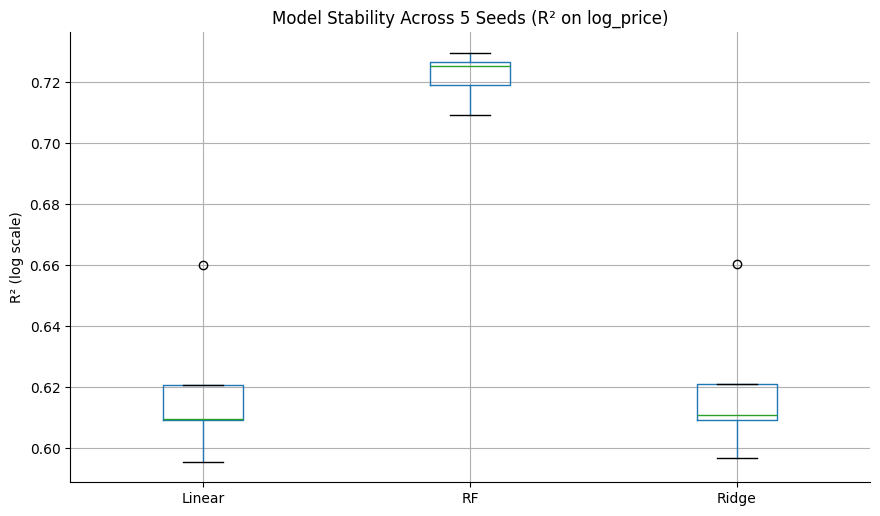

<Figure size 800x400 with 0 Axes>

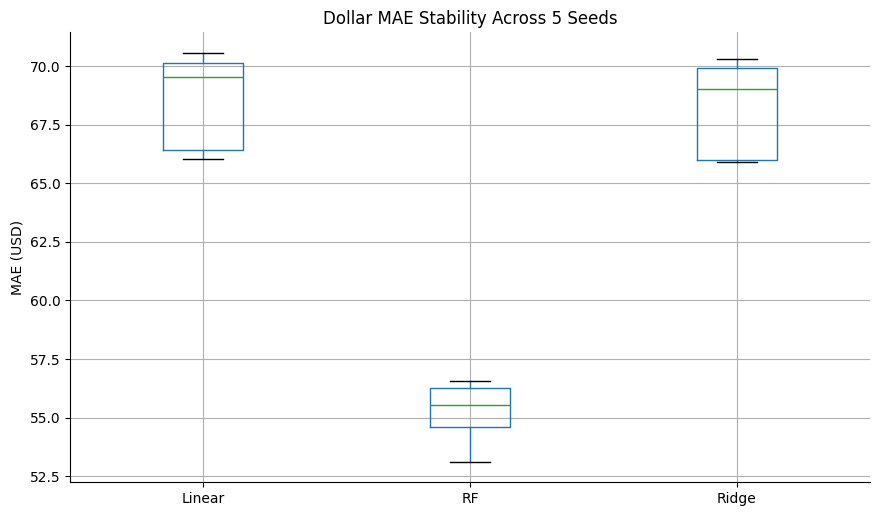

In [ ]:
# ===== 6b) Robustness: multi-seed evaluation + box plots =====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

seeds = [0, 1, 2, 3, 4]  # ≥5 seeds as required

def eval_model(pipe, X, y, seed):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=seed)
    m = pipe
    m.fit(X_tr, y_tr)
    pred = m.predict(X_te)
    # log-space metrics
    out = {
        "R2_log": r2_score(y_te, pred),
        "MAE_log": mean_absolute_error(y_te, pred),
        "RMSE_log": np.sqrt(mean_squared_error(y_te, pred)),
    }
    # back-transform to $
    yhat = np.expm1(pred)
    ytrue = np.expm1(y_te)
    out["MAE_$"] = mean_absolute_error(ytrue, yhat)
    out["RMSE_$"] = np.sqrt(mean_squared_error(ytrue, yhat))
    return out

models = {
    "Linear": lr_pipe,
    "Ridge":  ridge_pipe,
    "RF":     rf_pipe,
}

rows = []
X = df_flat.drop(columns=["log_price","id"], errors="ignore")
y = df_flat["log_price"]

for name, pipe in models.items():
    for s in seeds:
        # set underlying seed if model supports it (RF)
        try:
            if "model" in pipe.named_steps and hasattr(pipe.named_steps["model"], "random_state"):
                pipe.named_steps["model"].random_state = s
        except Exception:
            pass
        met = eval_model(pipe, X, y, seed=s)
        met.update({"Model": name, "Seed": s})
        rows.append(met)

res = pd.DataFrame(rows)
print("Summary by model (median ± IQR):")
display(
    res.groupby("Model").agg(
        R2_log_median=("R2_log", "median"),
        R2_log_IQR=("R2_log", lambda x: x.quantile(0.75) - x.quantile(0.25)),
        MAE_dollar_median=("MAE_$", "median"),
        MAE_dollar_IQR=("MAE_$", lambda x: x.quantile(0.75) - x.quantile(0.25))
    ).round(3)
)


# ---- Box plots (one metric that’s easy to explain) ----
plt.figure(figsize=(8,4))
res.boxplot(column="R2_log", by="Model")
plt.title("Model Stability Across 5 Seeds (R² on log_price)")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("R² (log scale)")
plt.show()

plt.figure(figsize=(8,4))
res.boxplot(column="MAE_$", by="Model")
plt.title("Dollar MAE Stability Across 5 Seeds")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("MAE (USD)")
plt.show()


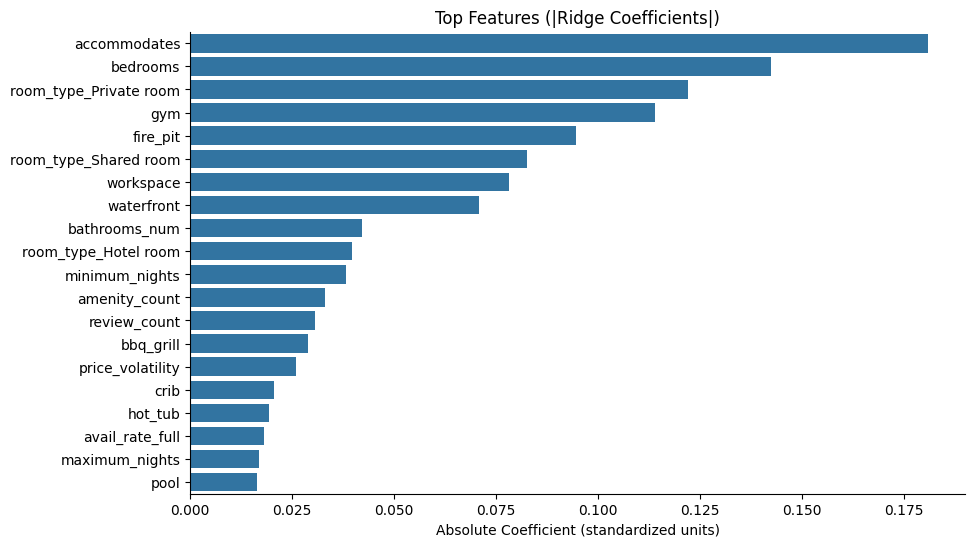

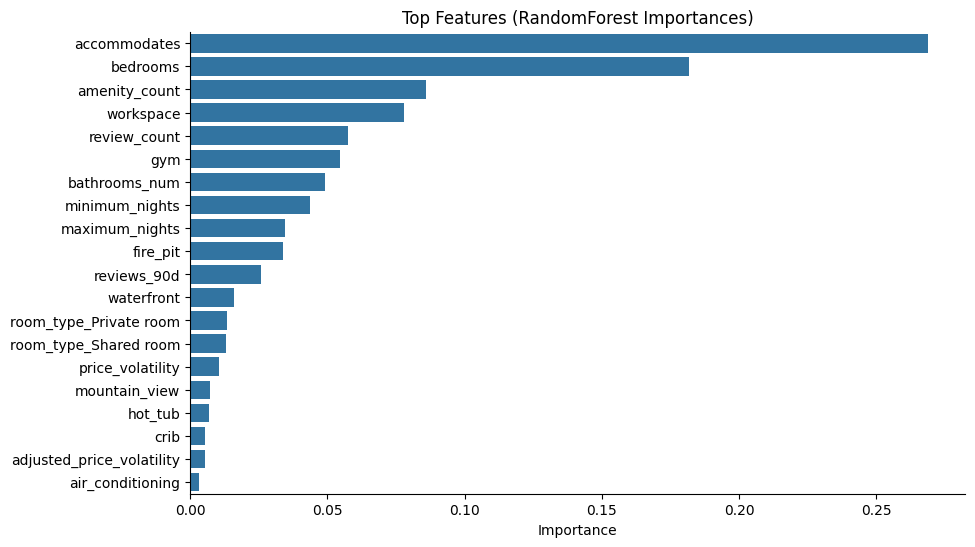

Saved: ridge_feature_importance_abs.csv, rf_feature_importance.csv


In [ ]:
# ===== 8) FEATURE IMPORTANCE (pipeline-safe & name-aligned) =====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_estimator(m):
    return m.named_steps["model"] if hasattr(m, "named_steps") else m

ridge_est = get_estimator(ridge)
rf_est    = get_estimator(rf)

# Ensure names align to the model's vector length
def align_names(values, names):
    values = np.asarray(values).ravel()
    if len(values) != len(names):
        # safest: trim/pad names to the vector length
        # (this happens if X changed after fitting)
        names = list(names)[:len(values)]
    return pd.Series(values, index=names)

# --- Ridge: absolute coefficients as importance proxy ---
ridge_abs = align_names(np.abs(ridge_est.coef_), FEATURE_NAMES).sort_values(ascending=False)

topn = 20
sns.barplot(x=ridge_abs.head(topn).values, y=ridge_abs.head(topn).index, orient="h")
plt.title("Top Features (|Ridge Coefficients|)")
plt.xlabel("Absolute Coefficient (standardized units)")
plt.ylabel("")
plt.show()

# --- RandomForest: impurity-based importances ---
rf_imp = align_names(rf_est.feature_importances_, FEATURE_NAMES).sort_values(ascending=False)

sns.barplot(x=rf_imp.head(topn).values, y=rf_imp.head(topn).index, orient="h")
plt.title("Top Features (RandomForest Importances)")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()

# Save full rankings for your report
ridge_abs.to_csv("ridge_feature_importance_abs.csv")
rf_imp.to_csv("rf_feature_importance.csv")
print("Saved: ridge_feature_importance_abs.csv, rf_feature_importance.csv")


In [ ]:
# ===== 9) SAVE TIDY OUTPUTS =====
OUT_DIR = "/content" if not USE_GOOGLE_DRIVE else os.path.join(BASE_DIR, "data")
os.makedirs(OUT_DIR, exist_ok=True)

df_fe.to_csv(os.path.join(OUT_DIR, "seattle_listings_engineered.csv"), index=False)
df_flat.to_csv(os.path.join(OUT_DIR, "modeling_table.csv"), index=False)

print("✅ Wrote:")
print("  •", os.path.join(OUT_DIR, "seattle_listings_engineered.csv"))
print("  •", os.path.join(OUT_DIR, "modeling_table.csv"))


✅ Wrote:
  • /content/drive/MyDrive/airbnb_seattle/data/seattle_listings_engineered.csv
  • /content/drive/MyDrive/airbnb_seattle/data/modeling_table.csv


In [ ]:
# ===== EXECUTIVE SUMMARY EXPORTER (Colab) =====
# Creates a concise HTML (+ optional PDF) report with your final tables & plots.
# Looks for these (if present): cv_df, adv_df, ridge_abs (Series), rf_imp (Series)

import os, io, base64, textwrap, datetime, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- CONFIG ---------
MAKE_PDF = True                        # set False if you only want HTML
OUT_DIR  = "/content/drive/MyDrive"    # change to a folder you prefer
TITLE    = "Seattle Airbnb Pricing — Executive Summary"
SUBTITLE = "ANLY 699 Final Project"

# Ensure output dir exists
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
html_path = os.path.join(OUT_DIR, "Final_Project_Summary.html")
pdf_path  = os.path.join(OUT_DIR, "Final_Project_Summary.pdf")

def df_to_html(df: pd.DataFrame, caption: str):
    if df is None or not isinstance(df, pd.DataFrame) or df.empty:
        return ""
    # round common metrics if present
    df_disp = df.copy()
    for col in df_disp.columns:
        if any(k in col.lower() for k in ["r2", "rmse", "mae", "log"]):
            with np.errstate(all='ignore'):
                df_disp[col] = pd.to_numeric(df_disp[col], errors="ignore")
                if pd.api.types.is_numeric_dtype(df_disp[col]):
                    df_disp[col] = df_disp[col].astype(float).round(3)
    return f"""
    <figure>
      <figcaption style="font-weight:600;margin:8px 0">{caption}</figcaption>
      {df_disp.to_html(classes='table', border=0)}
    </figure>
    """

def plot_series_bar(s: pd.Series, title: str, topn=20):
    """Return base64-encoded PNG of a horizontal bar chart from a Series."""
    if s is None or not hasattr(s, "sort_values"):
        return ""
    s = s.dropna()
    if s.empty: return ""
    s_top = s.sort_values(ascending=False).head(topn)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(range(len(s_top)), s_top.values)
    ax.set_yticks(range(len(s_top)))
    ax.set_yticklabels(s_top.index)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Importance")
    fig.tight_layout()
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("ascii")

# ---- Collect sections if variables exist in your session ----
sections_html = []

# 0) Header
header = f"""
<h1 style="margin-bottom:0">{TITLE}</h1>
<p style="color:#555;margin-top:4px">{SUBTITLE} &middot; Generated {ts}</p>
<hr/>
"""
sections_html.append(header)

# 1) Brief intro
intro = """
<p>This summary compiles the final model performance, cross-validation stability, and
feature importance visualizations for the Seattle Airbnb pricing model. Metrics are reported
on log(price) and back-transformed into $ where applicable in the notebook. Tree-based models
are evaluated alongside linear baselines to balance interpretability and predictive power.</p>
"""
sections_html.append(intro)

# 2) Cross-validation table (cv_df)
cv_df = globals().get("cv_df", None)
sections_html.append(df_to_html(cv_df, "Cross-Validation (5-fold) — Mean ± Std"))

# 3) Advanced models comparison (adv_df)
adv_df = globals().get("adv_df", None)
sections_html.append(df_to_html(adv_df, "Advanced Models — Test Set Metrics"))

# 4) Feature Importance plots (Ridge and RF)
ridge_abs = globals().get("ridge_abs", None)  # expects a Series of abs(coefficients)
rf_imp    = globals().get("rf_imp", None)     # expects a Series of RF importances

img_blocks = []
img_ridge_b64 = plot_series_bar(ridge_abs, "Top Features — |Ridge Coefficients|", topn=20)
if img_ridge_b64:
    img_blocks.append(f"""
    <figure>
      <figcaption style="font-weight:600;margin:8px 0">Top Features — |Ridge Coefficients|</figcaption>
      <img src="data:image/png;base64,{img_ridge_b64}" style="max-width:100%;height:auto"/>
    </figure>
    """)

img_rf_b64 = plot_series_bar(rf_imp, "Top Features — RandomForest Importance", topn=20)
if img_rf_b64:
    img_blocks.append(f"""
    <figure>
      <figcaption style="font-weight:600;margin:8px 0">Top Features — RandomForest Importance</figcaption>
      <img src="data:image/png;base64,{img_rf_b64}" style="max-width:100%;height:auto"/>
    </figure>
    """)

if img_blocks:
    sections_html.append("<hr/>" + "".join(img_blocks))

# 5) Closing notes
closing = """
<hr/>
<h3>Notes</h3>
<ul>
  <li><b>Interpretation:</b> Ridge coefficients are in standardized units (post-scaling).
      RandomForest importances reflect split-based impurity reduction and capture non-linear interactions.</li>
  <li><b>Robustness:</b> 5-fold CV indicates stable performance across folds.</li>
  <li><b>Data:</b> Listing metadata + review activity + calendar availability rules.</li>
</ul>
"""
sections_html.append(closing)

# ---- Assemble HTML with light styling ----
STYLE = """
<style>
body { font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; line-height: 1.45; color:#222; }
.table { border-collapse: collapse; width: 100%; font-size: 0.95rem; }
.table th, .table td { border-bottom: 1px solid #eee; padding: 6px 8px; text-align: right; }
.table th:first-child, .table td:first-child { text-align: left; }
h1,h2,h3 { margin: 0.5rem 0; }
figure { margin: 0 0 16px 0; }
figcaption { font-size: 0.95rem; color:#333; }
hr { border: 0; border-top: 1px solid #ddd; margin: 16px 0; }
</style>
"""

html = f"<!doctype html><html><head><meta charset='utf-8'><title>{TITLE}</title>{STYLE}</head><body>" \
       + "\n".join(sections_html) + "</body></html>"

with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)

print(f"✅ Saved HTML: {html_path}")

# ---- Optional: HTML -> PDF via wkhtmltopdf (works in Colab)
if MAKE_PDF:
    try:
        # Install once; skip if already present
        os.system("apt-get install -y wkhtmltopdf xvfb > /dev/null 2>&1")
        cmd = f'xvfb-run wkhtmltopdf "{html_path}" "{pdf_path}"'
        rc = os.system(cmd)
        if rc == 0 and os.path.exists(pdf_path):
            print(f"✅ Saved PDF : {pdf_path}")
        else:
            print("⚠️ PDF conversion failed; HTML is available and can be printed to PDF.")
    except Exception as e:
        print("⚠️ PDF conversion error:", e)

# If you want an immediate download prompt in Colab:
try:
    from google.colab import files
    # files.download(html_path)     # uncomment to auto-download HTML
    # files.download(pdf_path)      # uncomment to auto-download PDF
except:
    pass


✅ Saved HTML: /content/drive/MyDrive/Final_Project_Summary.html
✅ Saved PDF : /content/drive/MyDrive/Final_Project_Summary.pdf
